# 雑草の生育期間を区別して分類器を作る（生育済み）

■グーグルドライブをマウント

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


■clusterディレクトリをカレントにコピー
※driveのデータを直接変更しないようにあらかじめコピーしておく

In [0]:
%cp -r ./drive/My\ Drive/cluster ./

■ディレクトリを作成

In [0]:
import os, shutil

# The directory where we will
# store our smaller dataset
base_dir = "./CLS"
if "CLS" not in os.listdir("./"):
  os.mkdir(base_dir)
else:
  print(base_dir, "は既に存在します")

train_index = "train"
train_dir = os.path.join(base_dir, train_index)
if train_index not in os.listdir(base_dir):
  os.mkdir(train_dir)
else:
  print(train_dir + "は既に存在します")

validation_index = "validation"
validation_dir = os.path.join(base_dir, validation_index)
if validation_index not in os.listdir(base_dir):
  os.mkdir(validation_dir)
else:
  print(validation_dir + "は既に存在します")

prediction_index = "prediction"
prediction_dir = os.path.join(base_dir, prediction_index)
if prediction_index not in os.listdir(base_dir):
  os.mkdir(prediction_dir)
else:
  print(prediction_dir + "は既に存在します")

#10分類のclassを入力
classes=["hakidamegiku","hosoaogeitou","ichibi",
         "inubie","kosendangusa","mameasagao",
         "mehishiba","ohishiba","oinutade","shiroza",]
dirs = os.listdir(base_dir)
for dir in dirs:
  for cls in classes:
    # Directory with our training pictures
    class_dir = os.path.join(base_dir, dir, cls)
    if cls not in os.listdir(base_dir + "/" + dir):
      os.mkdir(class_dir)
    else:
      print(class_dir, "は既に存在します")


■ディレクトリに画像をランダムに振り分け

In [0]:
from os.path import join
import random

clsdir = "./cluster"
base_dir = "./CLS"
dirs = os.listdir(base_dir)
weed_types = ["grown"]
weed_names = os.listdir(clsdir)
# ファイル（クラスごとに分かれている）を順番に読み取り
# train, validationデータを作成
for weed_name in weed_names:
  for weed_type in weed_types: 
    print(weed_name, "/",weed_type)
    file_names = os.listdir(os.path.join(clsdir, weed_name, weed_type))
    files100 = random.sample(file_names, int(100))
    num1 = 0
    num2 = 0
    for file_name in file_names:
      if  file_name in files100:
        if num1 >= 90:
          continue
        # 移動元のファイル
        path1 = os.path.join(clsdir, weed_name, weed_type, file_name)
        # 移動先のファイル
        path2= os.path.join(base_dir, "train", weed_name, file_name)
        # ファイルを移動
        new_path = shutil.move(path1, path2)
        # ファイルの存在確認
        print(os.path.exists(path2))
        num1 = num1 + 1
      else:
        if num2 >= 90:
          continue 
        # 移動元のファイル
        path1 = os.path.join(clsdir, weed_name, weed_type, file_name)
        # 移動先のファイル
        path2= os.path.join(base_dir, "validation", weed_name, file_name)
        # ファイルを移動
        new_path = shutil.move(path1, path2)
        # ファイルの存在確認
        print(os.path.exists(path2))
        num2 = num2 + 1

# predictionデータを作成
for weed_name in weed_names:
  for weed_type in weed_types:
    print(weed_name, "/",weed_type)
    file_names = os.listdir(os.path.join(clsdir, weed_name, weed_type))
    for file_name in file_names:      
      # 移動元のファイル
      path1 = os.path.join(clsdir, weed_name, weed_type, file_name)
      # 移動先のファイル
      path2= os.path.join(base_dir, "prediction", weed_name, file_name)
      # ファイルを移動
      new_path = shutil.move(path1, path2)
      # ファイルの存在確認
      print(os.path.exists(path2))


■解凍したファイルをそれぞれ訓練データと検証用のデータに分けます

In [0]:
import os 
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import keras.preprocessing.image as Image

input_size = 224

train_dir = "./CLS/train"
validation_dir = "./CLS/validation"
prediction_dir = "./CLS/prediction"


train_datagen = Image.ImageDataGenerator(
            featurewise_center = False,
            samplewise_center = False,
            featurewise_std_normalization = False,
            samplewise_std_normalization = False,
            zca_whitening = False,
            rotation_range = 90,
            width_shift_range = 0.3,
            height_shift_range = 0.3,
            horizontal_flip = True,
            vertical_flip = False,
            rescale=1./255
        )

val_datagen = Image.ImageDataGenerator(rescale=1./255)



train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(input_size,input_size),
            batch_size=10,
            class_mode='categorical'
        )

validation_generator = val_datagen.flow_from_directory(
            validation_dir,
            target_size=(input_size,input_size),
            batch_size=10,
            class_mode='categorical'
        )


prediction_generator = val_datagen.flow_from_directory(
            prediction_dir,
            target_size=(input_size,input_size),
            batch_size=10,
            class_mode='categorical'
        )


Using TensorFlow backend.


Found 1800 images belonging to 10 classes.
Found 1800 images belonging to 10 classes.
Found 400 images belonging to 10 classes.


■学習開始

In [0]:

#ファインチューニング+VGG+水増し。ここから実行してOK（VGG16をダウンロード）
from keras import models
from keras import layers
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.applications import VGG16
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import History, Callback
from keras.objectives import categorical_crossentropy
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.utils import to_categorical
from scipy.stats import mode
import os, pickle


def create_cnn():
  input_size=224
  #input_sizeは224,224までOK。

  vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(input_size,input_size, 3))
  last = vgg_conv.output

  vgg_conv.trainable = True

  set_trainable = False
  for layer in vgg_conv.layers:
    if layer.name == 'block5_conv1':
      set_trainable = True
    if set_trainable:
      layer.trainable = True
    else:
      layer.trainable = False

  mod = Flatten()(last)
  mod = Dense(256, activation='relu')(mod)
  #mod = Dropout(0.5)(mod)
  preds = Dense(10, activation='softmax')(mod)

  model = models.Model(vgg_conv.input, preds)

  return model


チェックポイントを定義(val lossが一番低い値の時にweightを保存)

In [0]:
class Checkpoint(Callback):
    def __init__(self, model, filepath):
        self.model = model
        self.filepath = filepath
        self.best_val_acc = 0.0
        self.best_val_loss = 0.1

    def on_epoch_end(self, epoch, logs):
        # val_accuracyが最大の時ににweightを保存する
        # if self.best_val_acc < logs["val_accuracy"]:
        #     self.model.save_weights(self.filepath)
        #     self.best_val_acc = logs["val_accuracy"]
        #     print("Weights saved.", self.best_val_acc)

        # val_lossが最小の時ににweightを保存する
        if self.best_val_loss > logs["val_loss"]:
            self.model.save_weights(self.filepath)
            self.best_val_loss = logs["val_loss"]
            print("Weights saved.", self.best_val_loss)
        # print(epoch + 1)

        # epochの最後にweightを保存する
        # if epoch == 99:
        #   print("epoch equals ", epoch)
        #   self.model.save_weights(self.filepath)
        #   self.best_val_loss = logs["val_loss"]
        #   print("Weights saved.", self.best_val_loss)

モデルを実行してアンサンブル学習させていきます

In [0]:
def train():
    print("train starts")
    hist = History()
    train_model = create_cnn()
    train_model.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
    cp = Checkpoint(train_model, f"weights.hdf5")
    train_model.fit_generator(train_generator,epochs=100,validation_data=validation_generator,callbacks=[hist, cp])      

    return hist.history




In [0]:
K.clear_session()
hist = train()

train starts
58892288/58889256 [==============================] - 2s 0us/step
Epoch 1/10
180/180 [==============================] - 37s 208ms/step - loss: 1.9215 - accuracy: 0.3128 - val_loss: 1.4175 - val_accuracy: 0.5072
Epoch 2/10
180/180 [==============================] - 32s 176ms/step - loss: 1.2208 - accuracy: 0.5628 - val_loss: 1.0132 - val_accuracy: 0.6928
Epoch 3/10
180/180 [==============================] - 32s 177ms/step - loss: 0.9258 - accuracy: 0.6706 - val_loss: 1.0386 - val_accuracy: 0.7433
Epoch 4/10
180/180 [==============================] - 31s 173ms/step - loss: 0.7663 - accuracy: 0.7411 - val_loss: 0.5136 - val_accuracy: 0.7900
Epoch 5/10
180/180 [==============================] - 31s 171ms/step - loss: 0.6420 - accuracy: 0.7750 - val_loss: 0.6233 - val_accuracy: 0.8228
Epoch 6/10
180/180 [==============================] - 30s 169ms/step - loss: 0.5627 - accuracy: 0.7989 - val_loss: 0.4200 - val_accuracy: 0.8150
Epoch 7/10
180/180 [==============================] 

■正解率と損失率をグラフ化

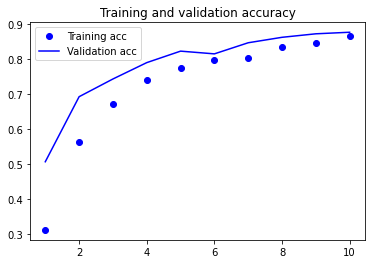

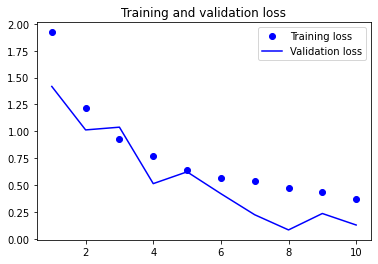

In [0]:
import matplotlib.pyplot as plt

history = hist

acc=history['accuracy']
val_acc=history['val_accuracy']
loss=history['loss']
val_loss=history['val_loss']

epochs=range(1,len(acc)+1)

#正解率plot
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()


#損失値をplot
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


■学習した分類器を単体で検証

weightをロードして単体で検証します

In [0]:
def sin_predict():
  
    train_model = create_cnn()
    train_model.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])

    # 最良のモデルの読み込み
    train_model.load_weights(f"weights.hdf5")
    for layer in train_model.layers:
        layer.trainable = False

    # 単体の推論
    single_preds = np.argmax(train_model.predict_generator(prediction_generator), axis=-1)

    # 推論のスコア
    test_acc = accuracy_score(prediction_generator.classes[prediction_generator.index_array], single_preds)

    print("Test Accuracy : ", test_acc)


In [0]:
# 単体の推論
sin_predict()

Test Accuracy :  0.8575
